In [110]:
import numpy as np
from pcgym import make_env
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.gridspec as gridspec
from tqdm import tqdm


In [58]:
def create_reactor_env():
    # Environment parameters
    nsteps = 60
    T = 26.0
    goal_state = 0.86
    SP = {
        'Ca': [goal_state for i in range(int(nsteps))],
    }
    
    # Action and observation spaces
    action_space = {
        'low': np.array([295.]),
        'high': np.array([302.])
    }
    observation_space = {
        'low': np.array([0.7, 315., 0.8], dtype=np.float32),
        'high': np.array([0.9, 335., 0.9], dtype=np.float32),
    }
    
    # Reward scale
    r_scale = {'Ca': 1e3}
    
    # Environment parameters
    env_params = {
        'N': nsteps,
        'tsim': T,
        'SP': SP,
        'o_space': observation_space,
        'a_space': action_space,
        'x0': np.array([0.7, 330, 0.8]),
        'model': 'cstr',
        'r_scale': r_scale,
        'normalise_a': True,
        'normalise_o': True,
        'noise': True,
        'integration_method': 'casadi',
        'noise_percentage': 0.001,
    }

    # Create environment
    env = make_env(env_params)
    return env

cont_env = create_reactor_env()

In [59]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Deep Q-network (DQN) agent
This is where you implement your code to update the Q-network, and decay the epsilon value.

In [ ]:
class DQN:
    def __init__(self, state_size, action_size, action_bounds, device="cpu"):
        self.state_size = state_size
        self.action_size = action_size  # Number of discrete actions
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.device = device
        
        # Discretize the action space
        self.action_low = action_bounds['low'][0]
        self.action_high = action_bounds['high'][0]
        self.discrete_actions = np.linspace(self.action_low, self.action_high, self.action_size)
        
        # Q-Networks
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        
        # Initialize target network with q_network weights
        self.update_target_network()
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        # Convert continuous action to discrete index
        action_idx = self._get_action_index(action[0])
        self.memory.append((state, action_idx, reward, next_state, done))
    
    def _get_action_index(self, continuous_action):
        # Find closest discrete action
        return np.argmin(np.abs(self.discrete_actions - continuous_action))
    
    def act(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            # Random action
            action_idx = random.randrange(self.action_size)
        else:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            
            # Get action values
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state_tensor)
            self.q_network.train()
            
            # Select best action
            action_idx = torch.argmax(action_values).item()
        
        # Convert discrete action to continuous
        return np.array([self.discrete_actions[action_idx]])
    
    def get_q_values(self, state):
        """Get Q-values for all actions at a given state"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        self.q_network.train()
        return q_values.cpu().numpy()[0]
    
    def get_best_action_and_value(self, state):
        """Get the best action and its Q-value for a given state"""
        q_values = self.get_q_values(state)
        best_action_idx = np.argmax(q_values)
        return self.discrete_actions[best_action_idx], q_values[best_action_idx]
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        
        states = np.array([experience[0] for experience in minibatch])
        actions = np.array([experience[1] for experience in minibatch])
        rewards = np.array([experience[2] for experience in minibatch])
        next_states = np.array([experience[3] for experience in minibatch])
        dones = np.array([experience[4] for experience in minibatch])
        
        # Convert to tensors
        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        dones_tensor = torch.FloatTensor(dones).to(self.device)
        
        # Get current Q values
        current_q_values = self.q_network(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values (Double DQN)
        with torch.no_grad():

            ##############################
            # YOUR CODE HERE
            # Get actions from policy network
            next_actions = 
            # Get Q-values from target network for those actions
            next_q_values = 
            # Compute target
            target_q_values = 
            ################################

        
        ###########################
        # Compute loss and update 
        # YOUR CODE HERE
        loss = 
        ############################


        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        #######################
        # YOUR CODE HERE
        # Update exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= 
        ########################
        return loss.item()
    
    def save(self, path):
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
    

In [109]:
def plot_policy_grid(self, state_ranges, fixed_states=None, resolution=20, selected_dims=[0, 1], plot_q_values=True):
    """
    Visualizes the policy as a grid, showing which action the agent would take at each state.
    
    Parameters:
    - state_ranges: dictionary with 'low' and 'high' for state space bounds
    - fixed_states: values for dimensions not being visualized
    - resolution: number of points in each dimension
    - selected_dims: which two dimensions to visualize [dim1, dim2]
    - plot_q_values: whether to plot detailed Q-values for different actions
    """
    if fixed_states is None:
        # Default fixed states (use midpoint of ranges for non-visualized dimensions)
        fixed_states = {}
        for i in range(self.state_size):
            if i not in selected_dims:
                fixed_states[i] = (state_ranges['low'][i] + state_ranges['high'][i]) / 2
    
    # Create grid of states
    x = np.linspace(state_ranges['low'][selected_dims[0]], 
                    state_ranges['high'][selected_dims[0]], 
                    resolution)
    y = np.linspace(state_ranges['low'][selected_dims[1]], 
                    state_ranges['high'][selected_dims[1]], 
                    resolution)
    
    # Arrays to store actions and values
    action_grid = np.zeros((resolution, resolution))
    value_grid = np.zeros((resolution, resolution))
    
    # If plotting Q-values, create a 3D array to store Q-values for each action at each state
    if plot_q_values:
        # Sample a subset of actions to visualize (otherwise too cluttered)
        q_actions_subset = np.linspace(0, self.action_size-1, min(5, self.action_size), dtype=int)
        q_values_grid = np.zeros((resolution, resolution, len(q_actions_subset)))
    
    # Iterate over all grid points
    for i, x_val in enumerate(x):
        for j, y_val in enumerate(y):
            # Create full state vector
            state = np.zeros(self.state_size)
            for k in range(self.state_size):
                if k == selected_dims[0]:
                    state[k] = x_val
                elif k == selected_dims[1]:
                    state[k] = y_val
                else:
                    state[k] = fixed_states[k]
            
            # Get best action and its value
            best_action, best_value = self.get_best_action_and_value(state)
            
            # Store in grid
            action_grid[j, i] = best_action  # Note the j,i indexing for correct orientation
            value_grid[j, i] = best_value
            
            # Store Q-values for all actions if requested
            if plot_q_values:
                all_q_values = self.get_q_values(state)
                for idx, action_idx in enumerate(q_actions_subset):
                    q_values_grid[j, i, idx] = all_q_values[action_idx]
    
    if plot_q_values:
        # Create a larger figure for detailed Q-value visualization
        fig = plt.figure(figsize=(20, 12))
        gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
        
        # Plot action grid
        ax1 = plt.subplot(gs[0, 0])
        im1 = ax1.imshow(action_grid, origin='lower', aspect='auto', 
                        extent=[x.min(), x.max(), y.min(), y.max()],
                        cmap='viridis')
        plt.colorbar(im1, ax=ax1, label='Action (Temperature)')
        ax1.set_xlabel(f'State dimension {selected_dims[0]}')
        ax1.set_ylabel(f'State dimension {selected_dims[1]}')
        ax1.set_title('Optimal Action Map')
        
        # Plot value grid
        ax2 = plt.subplot(gs[0, 1])
        im2 = ax2.imshow(value_grid, origin='lower', aspect='auto', 
                        extent=[x.min(), x.max(), y.min(), y.max()],
                        cmap='plasma')
        plt.colorbar(im2, ax=ax2, label='Best Q-Value')
        ax2.set_xlabel(f'State dimension {selected_dims[0]}')
        ax2.set_ylabel(f'State dimension {selected_dims[1]}')
        ax2.set_title('Value Function Map')
        
        # Plot Q-value difference between best and worst action
        ax3 = plt.subplot(gs[0, 2])
        q_diff = np.zeros((resolution, resolution))
        for i in range(resolution):
            for j in range(resolution):
                q_vals = [q_values_grid[j, i, idx] for idx in range(len(q_actions_subset))]
                q_diff[j, i] = max(q_vals) - min(q_vals)
        
        im3 = ax3.imshow(q_diff, origin='lower', aspect='auto',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      cmap='coolwarm')
        plt.colorbar(im3, ax=ax3, label='Q-value Difference')
        ax3.set_xlabel(f'State dimension {selected_dims[0]}')
        ax3.set_ylabel(f'State dimension {selected_dims[1]}')
        ax3.set_title('Q-value Gap (Best - Worst)')
        
        # Plot Q-value surfaces for specific actions
        for idx, action_idx in enumerate(q_actions_subset):
            ax = plt.subplot(gs[1, idx % 3])
            action_value = self.discrete_actions[action_idx]
            im = ax.imshow(q_values_grid[:, :, idx], origin='lower', aspect='auto',
                        extent=[x.min(), x.max(), y.min(), y.max()],
                        cmap='viridis')
            plt.colorbar(im, ax=ax, label='Q-Value')
            ax.set_xlabel(f'State dimension {selected_dims[0]}')
            ax.set_ylabel(f'State dimension {selected_dims[1]}')
            ax.set_title(f'Q-Values for Action {action_value:.2f}')
            
            # Only plot up to 3 action Q-values
            if idx >= 2:
                break
        
    else:
        # Create standard figure with just policy and value function
        fig = plt.figure(figsize=(15, 7))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
        
        # Plot action grid
        ax1 = plt.subplot(gs[0])
        im1 = ax1.imshow(action_grid, origin='lower', aspect='auto', 
                        extent=[x.min(), x.max(), y.min(), y.max()],
                        cmap='viridis')
        plt.colorbar(im1, ax=ax1, label='Action (Temperature)')
        ax1.set_xlabel(f'State dimension {selected_dims[0]}')
        ax1.set_ylabel(f'State dimension {selected_dims[1]}')
        ax1.set_title('Optimal Action Map')
        
        # Plot value grid
        ax2 = plt.subplot(gs[1])
        im2 = ax2.imshow(value_grid, origin='lower', aspect='auto', 
                        extent=[x.min(), x.max(), y.min(), y.max()],
                        cmap='plasma')
        plt.colorbar(im2, ax=ax2, label='Q-Value')
        ax2.set_xlabel(f'State dimension {selected_dims[0]}')
        ax2.set_ylabel(f'State dimension {selected_dims[1]}')
        ax2.set_title('Value Function Map')
    
    plt.tight_layout()
    return fig
setattr(DQN, "plot_policy_grid", plot_policy_grid)

In [ ]:
def train_dqn(env, episodes=200, device="cpu", visualize_interval=50):
    """Train the DQN agent on the given environment"""
    state_size = env.observation_space.shape[0]
    action_size = 21  # More discrete actions for finer control
    
    action_bounds = {
        'low': env.action_space.low,
        'high': env.action_space.high
    }
    
    state_ranges = {
        'low': env.observation_space.low,
        'high': env.observation_space.high
    }
    
    agent = DQN(state_size, action_size, action_bounds, device=device)
    scores = []
    progress_bar = tqdm(range(episodes), desc="Training Progress")
    # Use tqdm for progress tracking
    for e in progress_bar:
        state, _ = env.reset()
        total_reward = 0
        episode_losses = []
        
        for time in range(env.N):  # Number of steps per episode
            # Select action
            action = agent.act(state)
            
            # Take action
            next_state, reward, done, _, _ = env.step(action)
            
            # Remember experience
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            
            # Train the agent
            loss = agent.train()
            
            if done:
                break
        
        # Update target network every 5 episodes
        if e % 5 == 0:
            agent.update_target_network()
            
        # Track metrics
        scores.append(total_reward)
        
        # Update progress bar with current loss
        progress_bar.set_postfix({
        'Reward': f"{total_reward:.2f}", 
        'Epsilon': f"{agent.epsilon:.3f}"
        })
        
        
    # Plot training rewards
    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='Episode Rewards', alpha=0.3)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    # Add smoothed trend line
    window_size = min(2, len(scores))
    smoothed_rewards = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
    x_values = range(window_size-1, len(scores))
    plt.plot(x_values, smoothed_rewards, 'tab:red', linewidth=2, label='Rolling Mean')

    # Calculate rolling standard deviation
    rolling_std = np.array([np.std(scores[max(0, i-window_size+1):i+1]) for i in range(window_size-1, len(scores))])

    # Add the standard deviation as a fill between area around the rolling mean
    plt.fill_between(x_values, smoothed_rewards - rolling_std, smoothed_rewards + rolling_std, 
                    alpha=0.3, color='tab:red', label='Rolling Mean ± Std Dev', edgecolor='none')

    plt.legend()
    plt.show()
    
    return agent, scores

Using device: cpu


Training Progress: 100%|██████████| 100/100 [00:11<00:00,  8.50it/s, Reward=-12.09, Epsilon=0.010]


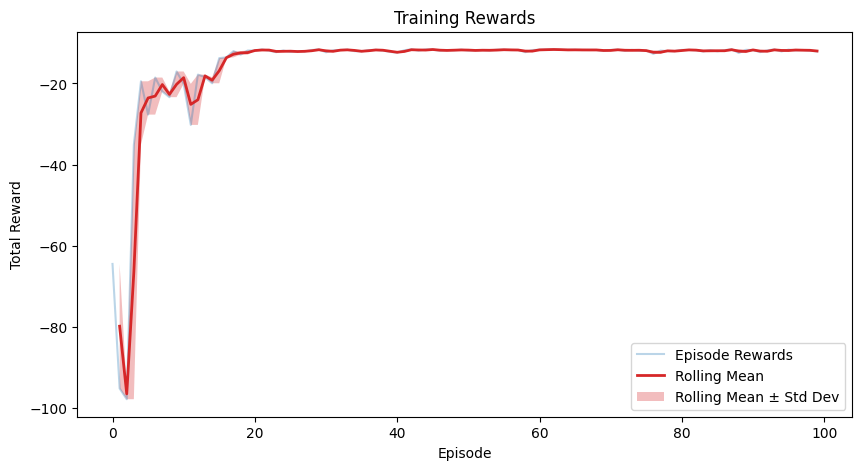

Training and visualization complete!


<Figure size 640x480 with 0 Axes>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the agent (assuming cont_env is already defined)
agent, scores = train_dqn(cont_env, episodes=100, device=device,)


In [119]:
def visualize_policy_rollout_with_values(env, agent, num_episodes=3, resolution=20):
    """
    Run the trained policy and visualize the rollouts with value function overlay
    
    Parameters:
    - env: Environment to run the policy in
    - agent: Trained DQN agent
    - num_episodes: Number of episodes to run and visualize
    - resolution: Resolution of the value function grid
    """

    # Get state space bounds
    state_ranges = {
        'low': env.env_params['o_space']['low'],
        'high': env.env_params['o_space']['high']
    }
    

    selected_dims = [0, 1]  
    
    # Create grid of states
    x = np.linspace(env.env_params['o_space']['low'][selected_dims[0]], 
                    env.env_params['o_space']['high'][selected_dims[0]], 
                    resolution)
    y = np.linspace(env.env_params['o_space']['low'][selected_dims[1]], 
                    env.env_params['o_space']['high'][selected_dims[1]], 
                    resolution)
    # Arrays to store actions and values
    action_grid = np.zeros((resolution, resolution))
    value_grid = np.zeros((resolution, resolution))
    
    # Iterate over all grid points to compute value function
    for i, x_val in enumerate(x):
        for j, y_val in enumerate(y):
            # Create full state vector
            state = np.zeros(agent.state_size)
            
            state[0] = 2 * (x_val - env.env_params['o_space']['low'][selected_dims[0]]) / (env.env_params['o_space']['high'][selected_dims[0]] - env.env_params['o_space']['low'][selected_dims[0]]) - 1
            state[1] = 2 * (y_val - env.env_params['o_space']['low'][selected_dims[1]]) / (env.env_params['o_space']['high'][selected_dims[1]] - env.env_params['o_space']['low'][selected_dims[1]]) - 1
            # Get best action and its value
            best_action, best_value = agent.get_best_action_and_value(state)
            action_low, action_high = env.env_params['a_space']['low'], env.env_params['a_space']['high']
            denormalized_best_action = action_low + (best_action + 1) * (action_high - action_low) / 2
            # Store in grid
            action_grid[i, j] = denormalized_best_action[0] # Note the j,i indexing for correct orientation
            value_grid[i, j] = best_value
    
    for episode in range(num_episodes):
        # Reset environment
        state, _ = env.reset()
        done = False
        
        # Track episode data
        states = [state.copy()]
        actions = []
        rewards = []
        total_reward = 0
        
        # Run episode
        step = 0
        while not done and step < env.N:
            # Select action using policy
            action = agent.act(state, training=False)
            # Take action
            next_state, reward, done, _, _ = env.step(action)
            
            # Store data
            actions.append(action[0])
            rewards.append(reward)
            total_reward += reward
            
            # Move to next state
            state = next_state
            states.append(state.copy())
            step += 1
        
        # Convert to numpy arrays for easier indexing
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)

        # Map states and actions from [-1, 1] to their actual ranges
        state_low, state_high = env.env_params['o_space']['low'], env.env_params['o_space']['high']
        denormalized_states = state_low + (states + 1) * (state_high - state_low) / 2

        action_low, action_high = env.env_params['a_space']['low'], env.env_params['a_space']['high']
        denormalized_actions = action_low + (actions + 1) * (action_high - action_low) / 2

        # Create figure for plotting
        fig = plt.figure(figsize=(20, 16))
        gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])
        
        
        
        ax2 = plt.subplot(gs[0, 0])
        ax2.plot(denormalized_states[:,0], label='Concentration (Ca)')
        ax2.axhline(y=0.86, color='r', linestyle='--', label='Goal (Ca=0.86)')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Ca')
        ax2.set_title('Ca Trajectory')
        ax2.legend()
        ax2.grid(True)
        

        # Plot actions
        ax4 = plt.subplot(gs[0, 1])
        ax4.plot(denormalized_actions, label='Action (Temperature)')
        ax4.set_xlabel('Step')
        ax4.set_ylabel('Temperature')
        ax4.set_title('Action Trajectory')
        ax4.legend()
        ax4.grid(True)
        
        
        
        ax7 = plt.subplot(gs[1, 0])
        # Plot value function
        im = ax7.imshow(value_grid, origin='lower', aspect='auto', 
                         extent=[state_ranges['low'][1], state_ranges['high'][1], 
                                state_ranges['low'][0], state_ranges['high'][0]],
                         cmap='plasma', alpha=0.7)
        plt.colorbar(im, ax=ax7, label='Value')
        
        # Overlay agent trajectory
        ax7.plot(denormalized_states[:-1, 1], denormalized_states[:-1, 0], 'k-', alpha=0.8)
        ax7.scatter(denormalized_states[0, 1], denormalized_states[0, 0], color='green', s=100, label='Start')
        ax7.scatter(denormalized_states[-2, 1], denormalized_states[-2, 0], color='red', s=100, label='End')
        ax7.axhline(y=0.86, color='r', linestyle='--', alpha=0.5, label='Goal (Ca=0.86)')
        
        ax7.set_xlabel('Temperature')
        ax7.set_ylabel('Ca')
        ax7.set_title('Value Function with Trajectory')
        ax7.legend()
        
        # New 2: Action selection overlay with trajectory
        ax8 = plt.subplot(gs[1, 1])
        # Plot policy (action selection)
        im = ax8.imshow(action_grid, origin='lower', aspect='auto', 
                         extent=[state_ranges['low'][1], state_ranges['high'][1], 
                                state_ranges['low'][0], state_ranges['high'][0]],
                         cmap='viridis', alpha=0.7)
        plt.colorbar(im, ax=ax8, label='Action (Temperature)')
        
        # Overlay agent trajectory with action colors
        points = ax8.scatter(denormalized_states[:-1, 1], denormalized_states[:-1, 0], 
                             c=denormalized_actions, cmap='viridis', 
                             s=50, edgecolor='k')
        
        ax8.plot(denormalized_states[:-1, 1], denormalized_states[:-1, 0], 'k-', alpha=0.3)
        ax8.scatter(denormalized_states[0, 1], denormalized_states[0, 0], color='green', s=100, label='Start')
        ax8.scatter(denormalized_states[-2, 1], denormalized_states[-2, 0], color='red', s=100, label='End')
        ax8.axhline(y=0.86, color='r', linestyle='--', alpha=0.5, label='Goal (Ca=0.86)')
        
        ax8.set_xlabel('Temperature')
        ax8.set_ylabel('Ca')
        ax8.set_title('Policy Map with Trajectory')
        ax8.legend()
    
        plt.tight_layout()
        plt.suptitle(f'Policy Rollout with Value Function - Episode {episode} (Total Reward: {total_reward:.2f})', fontsize=16)
        plt.subplots_adjust(top=0.95)
        
        plt.show()





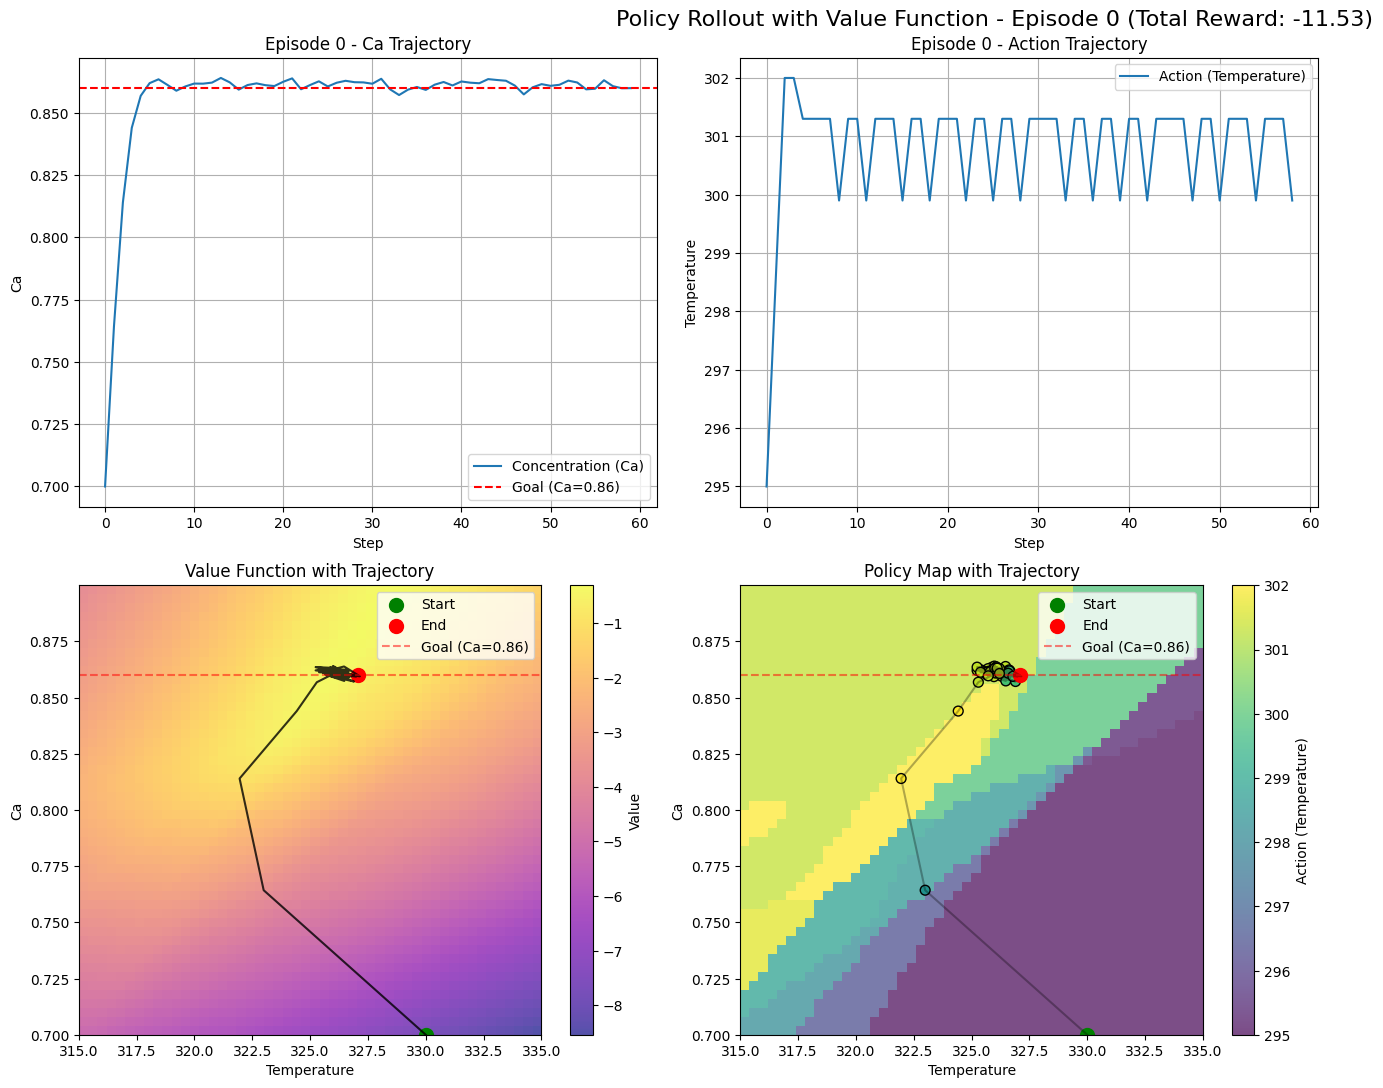

In [96]:
visualize_policy_rollout_with_values(cont_env, agent, num_episodes=1, resolution=50)